# Import

In [1]:
import astropy.units as u
from astropy.coordinates.sky_coordinate import SkyCoord
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import os
import copy

from kesacco import clustpipe

# Parameters

### Define the simulation

In [2]:
cpipe = clustpipe.ClusterPipe(silent=False, output_dir='/Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev')

             _  __  ___    __    __     ___   ___   __         
            | |/ / | __| /' _/  /  \   / _/  / _/  /__\        
            |   <  | _|  `._`. | /\ | | \__ | \__ | \/ |       
            |_|\_\ |___| |___/ |_||_|  \__/  \__/  \__/        
Keen Event Simulation and Analysis for CTA Cluster Observations
---------------------------------------------------------------


### Define the cluster object

In [3]:
# Set the cluster basic properties
cpipe.cluster.name     = 'Perseus'
cpipe.cluster.redshift = 0.017284
cpipe.cluster.M500     = 6.2e14*u.solMass # Used for getting R500 and the pressure profile
cpipe.cluster.coord    = SkyCoord("3h19m47.2s +41d30m47s", frame='icrs')

# Truncate the cluster at 1.5 deg to allow small map field of view (for faster code) without loss of flux
cpipe.cluster.theta_truncation = 1.5*u.deg

# The target gas density [Churazov et al. 2003]
cpipe.cluster.density_gas_model = {'name':'doublebeta', 'beta1':1.2, 'r_c1':57*u.kpc, 'n_01':0.046*u.cm**-3,
                                   'beta2':0.71, 'r_c2':278*u.kpc, 'n_02':0.0036*u.cm**-3}

# The thermal profile (assuming Planck 2013 UPP)
cpipe.cluster.set_pressure_gas_gNFW_param('P13UPP')

# CR physics
cpipe.cluster.spectrum_crp_model = {'name':'PowerLaw', 'Index':2.2}
cpipe.cluster.set_density_crp_isobaric_scal_param(scal=0.5)
cpipe.cluster.X_crp_E = {'X':10.0, 'R_norm':cpipe.cluster.R500}

# Sampling
cpipe.cluster.map_reso = 0.01*u.deg      # Ideally should be few times smaller than the PSF
cpipe.cluster.Npt_per_decade_integ = 30

# Get information about the state of the cluster model
cpipe.cluster.print_param()

--- silent
    True
    <class 'bool'>
--- output_dir
    /Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev
    <class 'str'>
--- cosmo
    FlatLambdaCDM(name="Planck15", H0=67.7 km / (Mpc s), Om0=0.307, Tcmb0=2.725 K, Neff=3.05, m_nu=[0.   0.   0.06] eV, Ob0=0.0486)
    <class 'astropy.cosmology.core.FlatLambdaCDM'>
--- name
    Perseus
    <class 'str'>
--- coord
    <SkyCoord (ICRS): (ra, dec) in deg
    (49.94666667, 41.51305556)>
    <class 'astropy.coordinates.sky_coordinate.SkyCoord'>
--- redshift
    0.017284
    <class 'float'>
--- D_ang
    74.8907830317466 Mpc
    <class 'astropy.units.quantity.Quantity'>
--- D_lum
    77.50198024167615 Mpc
    <class 'astropy.units.quantity.Quantity'>
--- M500
    620000000000000.0 solMass
    <class 'astropy.units.quantity.Quantity'>
--- R500
    1317.548394363056 kpc
    <class 'astropy.units.quantity.Quantity'>
--- theta500
    1.0080007077672122 deg
    <class 'astropy.units.quantity.Quantity'>
--- R_truncation
    1.9606361149510187 Mpc

### Define the point source object

In [4]:
name='NGC1275'
spatial={'type':'PointSource',
         'param':{'RA': {'value':SkyCoord("3h19m48.16s +41d30m42s").ra.to('deg'),  'free':False},
                  'DEC':{'value':SkyCoord("3h19m48.16s +41d30m42s").dec.to('deg'), 'free':False}}}
spectral={'type':'PowerLaw',
          'param':{'Prefactor':{'value':2.1e-11/u.cm**2/u.TeV/u.s, 'free':True},
                   'Index':{'value':-3.6, 'free':True},
                   'PivotEnergy':{'value':0.2*u.TeV, 'free':False}}}

cpipe.compact_source.add_source(name, spatial, spectral) # Add the source to the model

In [5]:
name='IC310'
spatial={'type':'PointSource',
         'param':{'RA': {'value':SkyCoord("3h16m42.98s +41d19m30s").ra.to('deg'),  'free':False},
                  'DEC':{'value':SkyCoord("3h16m42.98s +41d19m30s").dec.to('deg'), 'free':False}}}
spectral={'type':'PowerLaw',
          'param':{'Prefactor':{'value':4.3e-12/u.cm**2/u.TeV/u.s, 'free':True},
                   'Index':{'value':-1.95, 'free':True},
                   'PivotEnergy':{'value':1.0*u.TeV, 'free':False}}}

cpipe.compact_source.add_source(name, spatial, spectral)# Add the source to the model

In [6]:
# Show the status of the compact sources in the sky model
cpipe.compact_source.print_source()

--- NGC1275
    -- Spatial model: PointSource
         RA: {'value': <Longitude 49.95066667 deg>, 'free': False}
         DEC: {'value': <Latitude 41.51166667 deg>, 'free': False}
    -- Spectral model: PowerLaw
         Prefactor: {'value': <Quantity 2.1e-11 1 / (cm2 s TeV)>, 'free': True}
         Index: {'value': -3.6, 'free': True}
         PivotEnergy: {'value': <Quantity 0.2 TeV>, 'free': False}
    -- Temporal model: Constant
         Normalization: {'value': 1.0, 'free': False}
--- IC310
    -- Spatial model: PointSource
         RA: {'value': <Longitude 49.17908333 deg>, 'free': False}
         DEC: {'value': <Latitude 41.325 deg>, 'free': False}
    -- Spectral model: PowerLaw
         Prefactor: {'value': <Quantity 4.3e-12 1 / (cm2 s TeV)>, 'free': True}
         Index: {'value': -1.95, 'free': True}
         PivotEnergy: {'value': <Quantity 1. TeV>, 'free': False}
    -- Temporal model: Constant
         Normalization: {'value': 1.0, 'free': False}


### Define the observations

In [7]:
# One pointing offset +0 +0
cpipe.obs_setup.add_obs(obsid='001', name='Perseus_Ptg1', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value+0, cpipe.cluster.coord.dec.value+1.0, unit='deg'),
                        rad=5*u.deg,
                        emin=0.05*u.TeV, emax=100*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-01T00:00:00.0', tmax='2020-01-01T00:30:00.0', deadc=0.95)

# One pointing offset +sqrt(3)/2 -0.5
cpipe.obs_setup.add_obs(obsid='002', name='Perseus_Ptg2', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value+np.sqrt(3)/2, cpipe.cluster.coord.dec.value-0.5, unit='deg'),
                        rad=5*u.deg, 
                        emin=0.05*u.TeV, emax=100*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-01T01:00:00.0', tmax='2020-01-01T01:30:00.0', deadc=0.95)

# One pointing offset -sqrt(3)/2 -0.5
cpipe.obs_setup.add_obs(obsid='003', name='Perseus_Ptg3', 
                        coord=SkyCoord(cpipe.cluster.coord.ra.value-np.sqrt(3)/2, cpipe.cluster.coord.dec.value-0.5, unit='deg'),
                        rad=5*u.deg,
                        emin=0.05*u.TeV, emax=100*u.TeV,
                        caldb='prod3b-v2', irf='North_z20_S_5h',
                        tmin='2020-01-01T02:00:00.0', tmax='2020-01-01T02:30:00.0', deadc=0.95)

# Print info
cpipe.obs_setup.print_obs()

=== Perseus_Ptg1, ObsID 001
        RA-Dec:    49.94666666666666, 42.51305555555555 deg
        GLON-GLAT: 150.0078784158764, -12.426877669678154 deg
        ROI rad: 5.0 deg
        tmin: 2020-01-01T00:00:00.0
        tmax: 2020-01-01T00:30:00.0
        emin: 0.05 TeV
        emax: 100.0 TeV
        deadc: 0.95
        caldb: prod3b-v2
        irf: North_z20_S_5h
        bkg: name Background, obsid None, spatial type CTAIrfBackground, spectral type PowerLaw
=== Perseus_Ptg2, ObsID 002
        RA-Dec:    50.8126920704511, 41.01305555555555 deg
        GLON-GLAT: 151.41415408419417, -13.314435526241189 deg
        ROI rad: 5.0 deg
        tmin: 2020-01-01T01:00:00.0
        tmax: 2020-01-01T01:30:00.0
        emin: 0.05 TeV
        emax: 100.0 TeV
        deadc: 0.95
        caldb: prod3b-v2
        irf: North_z20_S_5h
        bkg: name Background, obsid None, spatial type CTAIrfBackground, spectral type PowerLaw
=== Perseus_Ptg3, ObsID 003
        RA-Dec:    49.08064126288222, 41.01305

# Run the simulation

# Run the analysis

In [8]:
#----- Analysis parameters
cpipe.method_binned = True    # Do a binned analysis
cpipe.method_stack  = True    # Stack the event from different observations in a single analysis?
cpipe.method_ana    = '3D'    # 3D or ONOFF analysis
cpipe.spec_enumbins = 30
cpipe.spec_emin     = 50*u.GeV
cpipe.spec_emax     = 10*u.TeV
cpipe.spec_edisp    = False

# Force the use of the user defined map grid
cpipe.map_UsePtgRef     = True
# Define the map used for the binned analysis
cpipe.map_reso          = 0.05*u.deg # Can be increaded if the code is too slow
cpipe.map_fov           = 3*u.deg    # Can also be reduced (but should increase bkg-cluster degeneracy)
cpipe.map_coord         = copy.deepcopy(cpipe.cluster.coord)
# Define the map used for the template
cpipe.cluster.map_fov   = 2.1*cpipe.cluster.theta_truncation
cpipe.cluster.map_coord = copy.deepcopy(cpipe.cluster.coord)


      Starting the MCMC spectral imaging analysis     
      (including the background in the grid model)

    Existing sampler: /Users/adam/Project/CTA/Phys/Outputs/KESACCO_Dev/Ana_MCMC_SpecImg2/MCMC_sampler.pkl
nwalkers should be at least twice the number of parameters.
nwalkers --> 18

--- MCMC profile parameters: 
    ndim                = 9
    nwalkers            = 18
    nsteps              = 1000
    burnin              = 100
    conf                = 68.0
    reset_mcmc          = False
    Gaussian likelihood = False
--- Start from already existing sampler
param 0 (X_{CRp}/X_{CRp,0}): 
   median   = 0.9858823492083001 -0.03596868373083495 +0.044760298812605126
   best-fit = 0.9708419569484347 -0.02092829147096953 +0.059800691072470546
   X_{CRp}/X_{CRp,0} = 0.9858823492083001_{-0.03596868373083495}^{0.044760298812605126}
param 1 (\eta_{CRp}): 
   median   = 0.9612253339119521 -0.022019602873038946 +0.023919148472722584
   best-fit = 0.9570743150832679 -0.017868584044354763 +

(Pdb) MC_model['background']
array([[[[1.4958453 , 1.54933396, 1.60269639, ..., 1.60269638,
          1.54933395, 1.49584529],
         [1.55327519, 1.61030378, 1.66715647, ..., 1.66715645,
          1.61030376, 1.55327517],
         [1.61047245, 1.6709458 , 1.73119107, ..., 1.73119105,
          1.67094578, 1.61047243],
         ...,
         [1.52787396, 1.59621594, 1.6643546 , ..., 1.66435458,
          1.59621592, 1.52787394],
         [1.46348068, 1.53130962, 1.59888791, ..., 1.59888789,
          1.5313096 , 1.46348066],
         [1.39807321, 1.46551115, 1.5326293 , ..., 1.53262928,
          1.46551113, 1.39807319]],

        [[1.50966351, 1.56008536, 1.61048078, ..., 1.61048076,
          1.56008534, 1.5096635 ],
         [1.56147648, 1.61414772, 1.66678335, ..., 1.66678334,
          1.6141477 , 1.56147646],
         [1.61322407, 1.66812953, 1.72298936, ..., 1.72298935,
          1.66812951, 1.61322405],
         ...,
         [1.54390586, 1.60073477, 1.65750394, ..., 1.657503

(Pdb) MC_model['point_sources']
[array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0

(Pdb) len(MC_model['point_sources'])
2
(Pdb) plt.imshow(MC_model['point_sources'][0][0,0,:,:], origin='lower')
(Pdb) plt.imshow()
*** TypeError: imshow() missing 1 required positional argument: 'X'
(Pdb) plt.show()


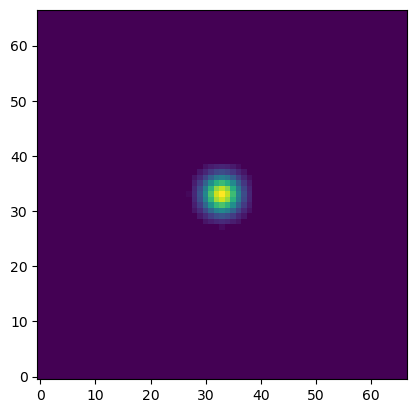

(Pdb) plt.imshow(MC_model['point_sources'][0][2,0,:,:], origin='lower')
(Pdb) plt.show()


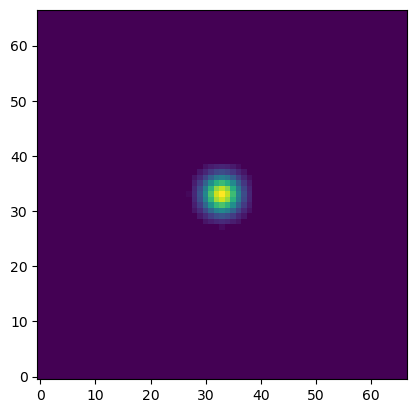

(Pdb) plt.imshow(MC_model['point_sources'][0][2,0,:,:], origin='lower')
(Pdb) plt.colorbar()
(Pdb) plt.show()


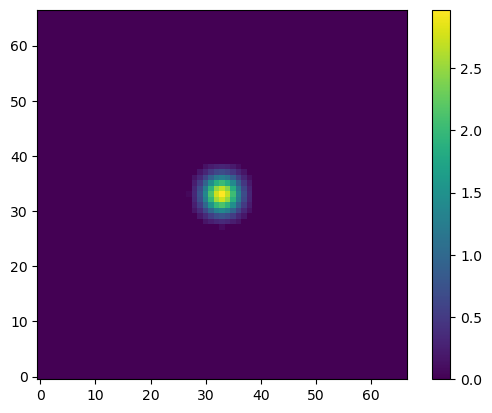

(Pdb) plt.imshow(MC_model['point_sources'][0][0,0,:,:], origin='lower')
(Pdb) plt.colorbar()
(Pdb) plt.show()


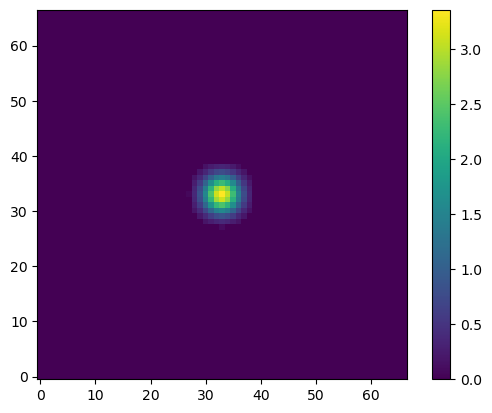

(Pdb)     Best_model = model_specimg(modgrid, par_best)
(Pdb) Best_model
{'cluster': array([[[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]],

       ...,

       [[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ...,

In [ ]:
cpipe.run_ana_mcmc_spectralimaging(reset_modelgrid=False,
                                   reset_mcmc=False, run_mcmc=False, GaussLike=False,
                                   spatial_range=[0.8,1.2], spatial_npt=5, spectral_range=[2.0,2.4], spectral_npt=5,
                                   bkg_marginalize=False,
                                   bkg_spectral_npt=5,bkg_spectral_range=[-0.2,0.2],
                                   ps_spectral_npt=5,ps_spectral_range=[-0.2,0.2],
                                   rm_tmp=False)